In [1]:
# Imports
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib/python')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_technology')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../../sra.h5', mode='r')

last updated: 2017-11-02 
Git hash: 77256d4c91158a79506f4adb8e290ae30d5f9ec0


In [53]:
# Constants


NOTE: ADD unique mapping at feature


# Sequencing Technology Classification

Next I want to use different feature types to classify data.

## Feature Counts

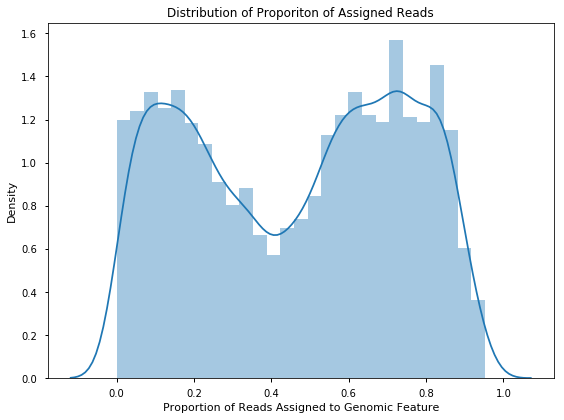

In [30]:
# Plot distribution of proportion assigned reads
@make_figs(nbconfig.fig_name('distplot_prop_assigned_reads'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/feature_counts/summary']
    df.set_index(['srx', 'srr'], inplace=True)
    df['total'] = df.sum(axis=1)
    df['prop_assigned'] = df.Assigned / df.total
    
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df.prop_assigned, ax=ax)
    
    ax.set_title('Distribution of Proporiton of Assigned Reads')
    ax.set_xlabel('Proportion of Reads Assigned to Genomic Feature')
    ax.set_ylabel('Density')
    
    return fig

plot(store)

In [33]:
df = store['prealn/workflow/markduplicates']

In [34]:
df.head()

,srx,srr,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,SRX2581987,SRR5278103,Unknown Library,608397,1777633,718566,30692893,551340,1434660,0,0.821551,344967.0
1,SRX2556775,SRR5251041,Unknown Library,764496,0,72476,1418095,676306,0,0,0.884643,NaN
2,SRX2556774,SRR5251040,Unknown Library,180326,0,19633,604487,128277,0,0,0.711362,NaN
3,SRX2556773,SRR5251039,Unknown Library,841415,0,95391,2022701,728862,0,0,0.866234,NaN
4,SRX2556772,SRR5251038,Unknown Library,639582,0,66892,1925506,534834,0,0,0.836224,NaN


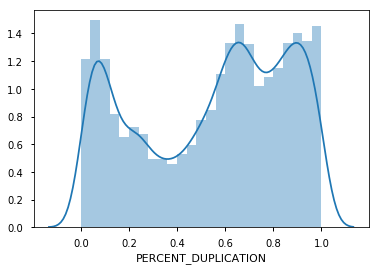

In [35]:
sns.distplot(df.PERCENT_DUPLICATION)

In [32]:
store.root.prealn.workflow.markduplicates

/prealn/workflow/markduplicates (Group) ''
  children := ['table' (Table)]

For example, in RNA-Seq experiments large amounts of multimapping reads indicate large either PCR duplication or a failure to remove rRNA during polyA selection. However, in ChIP-Seq experiments there is an enrichment for small regions of the genome leading to an expected decrease in library complexity. 

A sample may have a low unique mapping if that sample is contaminated or has low sequence complexity. There is a distinct distribution patter when looking at the distribution of proportion of unique mapping reads. This distribution resembles a normal distribution with a extremely fat tail on the lower end of values. The natural inflection point is around 0.3 or 0.35. Here I selected a quality cutoff of 0.3 (30% reads mapping uniquely).

Next I was interested in seeing if SRRs within an SRX have similar mapability. An SRR is supposed to be a technical replicate of an SRX. It is possible that if an SRX has highly variable SRRs that it may be made up of different libraries. There are other feature sets that I will explore regarding these relationships, here I just quickly look at the standard deviation of SRRs within an SRX. In general, the distribution looks almost normally distributed with a slight left skew toward smaller STDs as expected. By far the worst sample was (SRX352887: SRR989483) which had only 3 reads mapping uniquely, suggesting a contamination problem.

In [ ]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('distplot_unique_mapping'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    from ncbi_remap.prealn_wf import keep_rows
    se = store['prealn/workflow/hisat2/SE'][['srx', 'srr', 'num_reads', 'num_uniquely_aligned']]
    se['prop_unique_aligned'] = se['num_uniquely_aligned'] / se['num_reads']
    se = keep_rows(se, 'srr', mapping_ok.srr)

    pe = store['prealn/workflow/hisat2/PE'][['srx', 'srr', 'num_reads', 'num_concordant_reads_uniquely_aligned']]
    pe['prop_unique_aligned'] = pe['num_concordant_reads_uniquely_aligned'] / pe['num_reads']
    pe = keep_rows(pe, 'srr', mapping_ok.srr)

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_unique_aligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_unique_aligned, ax=ax, label='Pair Ended')
    ax.legend()
    ax.set_title('Distribution of Unique Mapping')
    ax.set_xlabel('Proportion of Uniquely Mapping Reads')
    ax.set_ylabel('Density');
    
plot(store)

In [22]:
from ncbi_remap.io import add_id, remove_id

#srx = 'SRX648309'
#srr = 'SRR1509506'

#store.select('prealn/complete', 'srr == {}'.format(srr))
#remove_id(store, 'prealn/complete', srr=srr)
#
#store.select('prealn/complete', 'srr == {}'.format(srr))
#add_id(store, 'prealn/complete', srx=srx, srr=srr)
#
#(store['prealn/complete'].srr == srr).any()